# Thermal Image Processing

In [8]:
# Load Modules
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from scipy import ndimage as ndi
from skimage import filters, segmentation, feature, morphology
from skimage.filters import threshold_local
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk
import imageio.v2 as imageio

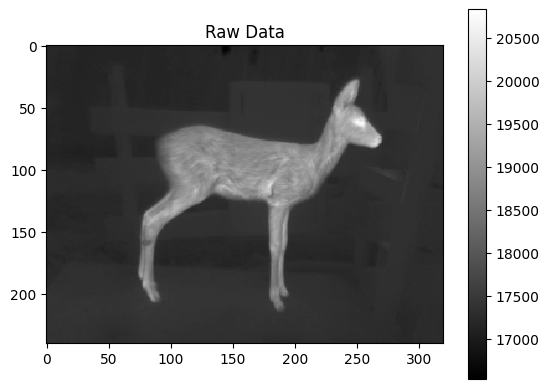

In [2]:
# Load in the thermal image
# A copy of the image has been uploaded to the "data" folder in the DeerCam GitHub repo 
img_filepath = "/Users/rhemitoth/Documents/PhD/Cembra/Deer_Cam/data/file-20240920-140026_burst2.tiff"
img = imageio.imread(img_filepath)

# Convert to numpy
image = np.array(img)

# Visualize the image

plt.title("Raw Data")
plt.imshow(image, interpolation='nearest',cmap = "grey")
plt.colorbar()

# Step 1: Segment the image

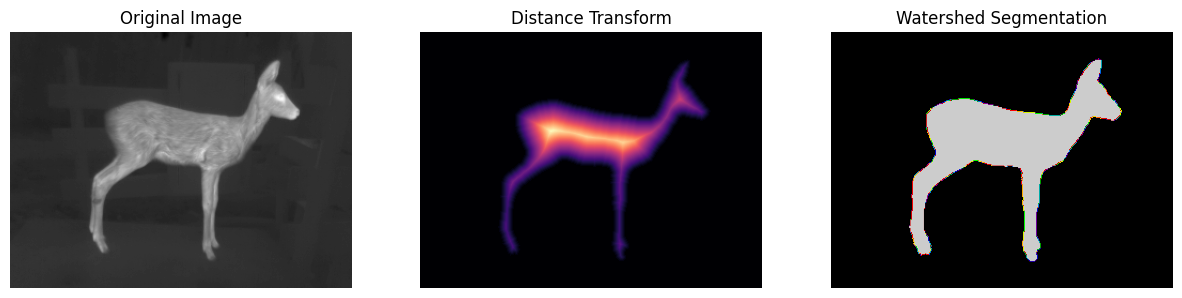

In [6]:
# Apply adaptive (local) thresholding to binarize the image.
# A large block size helps account for large-scale intensity variation (e.g., uneven illumination).
# A small offset lowers the threshold to include dimmer (colder) parts of the animal.
block_size = 601
adaptive_thresh = threshold_local(image, block_size, offset=5)
binary = image > adaptive_thresh

# Clean the binary mask:
# - Remove small objects likely to be noise or background.
# - Fill small holes within larger regions to create a more contiguous mask.
# - Apply morphological closing to smooth edges and close small gaps.
cleaned = remove_small_objects(binary, min_size=2000)  # Adjust min_size depending on object scale
cleaned = remove_small_holes(cleaned, area_threshold=2000)
cleaned = closing(cleaned, disk(3))  # Disk radius controls how aggressively gaps are closed

# Compute the distance transform of the cleaned mask.
# This gives the distance of each pixel inside the object to the nearest background pixel.
distance = ndi.distance_transform_edt(cleaned)

# Identify local maxima in the distance map as potential object centers (seeds).
# A large footprint suppresses nearby peaks, ensuring only the strongest centers are retained.
coordinates = feature.peak_local_max(distance, footprint=np.ones((150, 150)), labels=cleaned)

# Create a marker image from the coordinates of local maxima.
# Each peak becomes a separate region seed for the watershed.
markers = np.zeros_like(distance, dtype=int)
for i, coord in enumerate(coordinates, start=1):
    markers[tuple(coord)] = i

# Perform watershed segmentation using the negative distance map.
# This effectively "floods" the object outward from the markers until regions meet.
labels = segmentation.watershed(-distance, markers, mask=cleaned)

# Visualize results: original image, distance transform, and final labeled segments
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(distance, cmap='magma')
axes[1].set_title('Distance Transform')
axes[2].imshow(labels, cmap='nipy_spectral')
axes[2].set_title('Watershed Segmentation')
for ax in axes:
    ax.axis('off')
plt.show()


# Step 2: Extract the animal pixels using the segmentation results

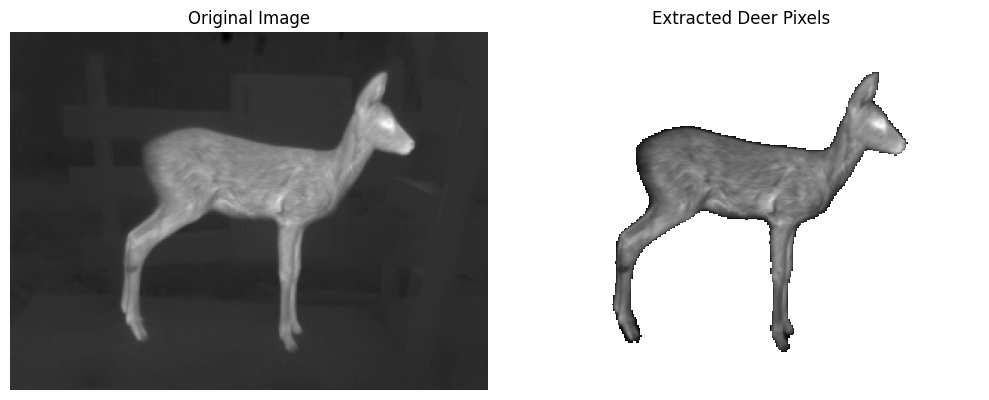

In [9]:
# Create a binary mask where background pixels (label == 0) are marked as True.
# These background pixels will be masked out in the next step.
mask = labels == 0  # Background is labeled as 0 after watershed

# Use a masked array to isolate deer pixels.
# Pixels corresponding to the background are masked (hidden), leaving only the segmented object(s).
deer_pixels = ma.masked_array(image, mask=mask)

# Set up a side-by-side comparison of the original image and the masked image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original grayscale image
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")

# Display the image with only the segmented (non-background) pixels visible
ax[1].imshow(deer_pixels, cmap='gray')
ax[1].set_title("Extracted Deer Pixels")

# Hide axis ticks and labels for a cleaner presentation
for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


# Step 3: Compute surface temperature

In [12]:
# FUNCTION TO CONVERT RAW FLIR DATA TO TEMPERATURE

def raw_to_temp(
    raw_array, 
    # Properties of the surroundings
    rh,
    t_air,
    t_win,
    LW,
    e_refl = 0.95,
    # Emissivity of target
    e_target = 0.95, 
    # Radiative transfer coefficients
    X = 1.9, 
    a1 = 0.01, 
    a2 = 0.01, 
    b1 = 0, 
    b2 = -0.01,
    # Planck Function Coefficients
    R1 = 17070.73, 
    R2 = 0.01160998, 
    B = 1437.2, 
    F = 1, 
    O = -7393, 
    # Enclosure Properties
    trans_win = 1,
    refl_win = 0,
    # Distance between the sensor and the targer
    dist = 1.415
    ):

    """

    Converts a NumPy array of raw data values to a NumPy array of surface temperature values. See Johnston et al. 2021 Appendix A for a full description of how to convert
    from raw data to temperature. 

    Args:
    rad_array (numpy array): NumPy array of radiance values.
    e_target (float):  Emissivity of the subject (usually 0.95 for an animal).
    X (float): Radiative transfer coefficeint. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    a1 (float): Radiative transfer coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    a2 (float): Radiative transfer coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    b1 (float): Radiative transfer coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    b2 (float): Radiative transfer coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    R1 (float): Planck function coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    R2 (float): Planck function coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    B (float): Planck function coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    F (float): Planck function coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    O (float): Planck function coefficient. Can be obtained by navigating to the features tab of the SpinView desktop application from the FLIR Spinnaker SDK. 
    trans_win (float): Transmissivity of the enclosure window (0-1).
    refl_win (float): Reflectivity of the enclosure window (0-1).
    dist (float): Distance the camera and the target (m).
    rh (float): Relative humidity of the air (0-1).
    t_air (float): Temperature of the air (Celcius).
    t_win (float): Temperature of the enclosure window (Celcius).
    LW (float): Longwave radiation of the surroundings (W/m2).
    e_refl (float): Emissivity of the surroundings (0-1).

    Returns:
    temp_array: NumPy array of temperature values

    """

    # Stefan-Boltzman Constant
    sigma = 5.670374419e-8

    # air water vapor concentration
    C_H2O = rh*math.exp(1.5587+6.939*(10**-2)*t_air-2.7816*(10**-4)*(t_air**2)+6.8455*(10**-7)*(t_air**3))

    # transmissivity of air
    trans_air = X*math.exp(-math.sqrt(dist)*(a1+b1*math.sqrt(C_H2O)))+(1-X)*math.exp(-math.sqrt(dist)*(a1+b2*math.sqrt(C_H2O)))

    # Sky temperature
    t_refl = (LW/sigma)**(0.25)

    # Energy of window
    phi_win = (R1/R2*(1/(math.exp(B/t_win)-F)))-O

    # Energy of air
    phi_air = (R1/R2*(1/(math.exp(B/t_air)-F)))-O

    # Reflected energy
    phi_refl = (R1/R2*(1/(math.exp(B/t_refl)-F)))-O

    # Energy of target
    phi_target = (raw_array/e_target/trans_air/trans_win) - (phi_refl*e_refl*(1-e_target)/e_target)-(phi_air*(1-trans_air)/e_target/trans_air)-(phi_win*(1-refl_win-trans_win)/e_target/trans_air/trans_win)

    # Target Temperature
    t_target_K = B/np.log(R1/(R2*(phi_target+O)+F)) # kelvin
    t_target = t_target_K - 273.15

    # Return result
    return(t_target)

In [13]:
# SET THE ENVIRONMENTAL VARIABLES
# These can be measured from a weather staion or modeled

ta = 17.11 # Air temperature
hum = 0.7 # Humidity
longwave = 200 # Longwave radiation of the environment

In [14]:
deer_temp = raw_to_temp(
    raw_array = deer_pixels, 
    # Properties of the surroundings
    rh = hum,
    t_air = ta,
    t_win = ta, # assumed that the camera housing window is the same temperature as the air
    LW = longwave)

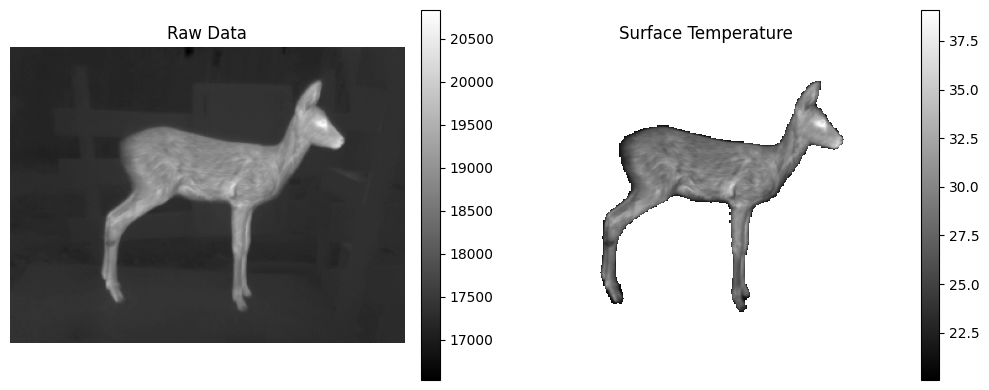

In [16]:
# Plot result
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Show original image and store the image handle
im0 = ax[0].imshow(image, cmap='gray')
ax[0].set_title("Raw Data")

# Show surface temperature and store the image handle
im1 = ax[1].imshow(deer_temp, cmap='gray')
ax[1].set_title("Surface Temperature")

# Add colorbars for each subplot
fig.colorbar(im0, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(im1, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)

# Remove axis ticks
for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()
